In [2]:

import os
import random
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt 
from IPython.display import Image
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model
from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D,MaxPooling2D,Flatten, MaxPooling3D

from sklearn.metrics import classification_report,confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Number of images in the training set:  14034
Number of images in the test set:  14034
Number of images in the prediction set:  7301


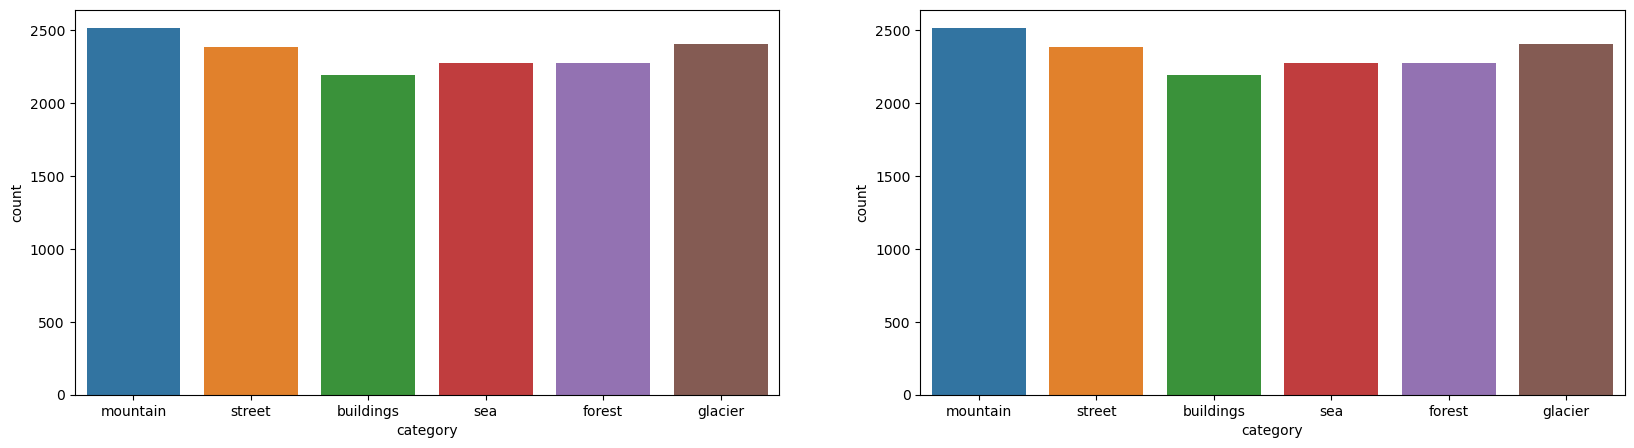

In [3]:
data_directory = '/kaggle/input/intel-image-classification/'
train_test_folders = os.listdir(data_directory)

train_folder = '../input/intel-image-classification/seg_train/seg_train/'
test_folder = '../input/intel-image-classification/seg_test/seg_test/'
prediction_folder = '../input/intel-image-classification/seg_pred/seg_pred/'
train_quantity, test_quantity = {}, {}

for folder in os.listdir(train_folder):
    train_quantity[folder] = len(os.listdir(train_folder + folder))

for folder in os.listdir(test_folder):
    test_quantity[folder] = len(os.listdir(train_folder + folder))

train_data_counts = pd.DataFrame(list(train_quantity.items()), index=range(0, len(train_quantity)), columns=['category', 'count'])
test_data_counts = pd.DataFrame(list(test_quantity.items()), index=range(0, len(test_quantity)), columns=['category', 'count'])

figure, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot(x='category', y='count', data=train_data_counts, ax=axes[0])
sns.barplot(x='category', y='count', data=test_data_counts, ax=axes[1])

print("Number of images in the training set: ", sum(train_quantity.values()))
print("Number of images in the test set: ", sum(test_quantity.values()))
num_images_in_prediction_set = len(os.listdir(prediction_folder))
print("Number of images in the prediction set: ", num_images_in_prediction_set)

plt.show()


In [4]:
def save_training_history(history, model_name):
    history_df = pd.DataFrame(history.history)
    
    history_json_file = model_name + '_training_history.json'
    with open(history_json_file, mode='w') as f:
        history_df.to_json(f)
        
    history_csv_file = model_name + '_training_history.csv'
    with open(history_csv_file, mode='w') as f:
        history_df.to_csv(f)
    

def plot_accuracy_from_training_history(history, is_inception=False):
    color_palette = sns.color_palette()
    if is_inception == False:
        train_acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        train_acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        
    epochs = range(len(train_acc))
    
    sns.lineplot(x=epochs, y=train_acc, label='Training Accuracy')
    sns.lineplot(x=epochs, y=val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
    
def plot_loss_from_training_history(history):
    color_palette = sns.color_palette()
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(train_loss))
    
    sns.lineplot(x=epochs, y=train_loss, label='Training Loss')
    sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def process_training_history(history, history_file_name, is_inception=False):
    save_training_history(history, history_file_name)
    plot_accuracy_from_training_history(history, is_inception)
    plot_loss_from_training_history(history)


In [5]:
train_data_augmentation = ImageDataGenerator(rescale=1.0/255., shear_range=0.2, zoom_range=0.2)

train_data_iterator = train_data_augmentation.flow_from_directory(train_folder,
                                                                  batch_size=32,
                                                                  shuffle=True,
                                                                  class_mode='categorical',
                                                                  target_size=(150, 150))

validation_data_augmentation = ImageDataGenerator(rescale=1.0/255)

validation_data_iterator = validation_data_augmentation.flow_from_directory(test_folder,
                                                                            shuffle=True,
                                                                            batch_size=1,
                                                                            class_mode='categorical',
                                                                            target_size=(150, 150))


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [6]:
inverse_class_mapping = {v: k for k, v in validation_data_iterator.class_indices.items()}
print(validation_data_iterator.class_indices)
print(inverse_class_mapping)



{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


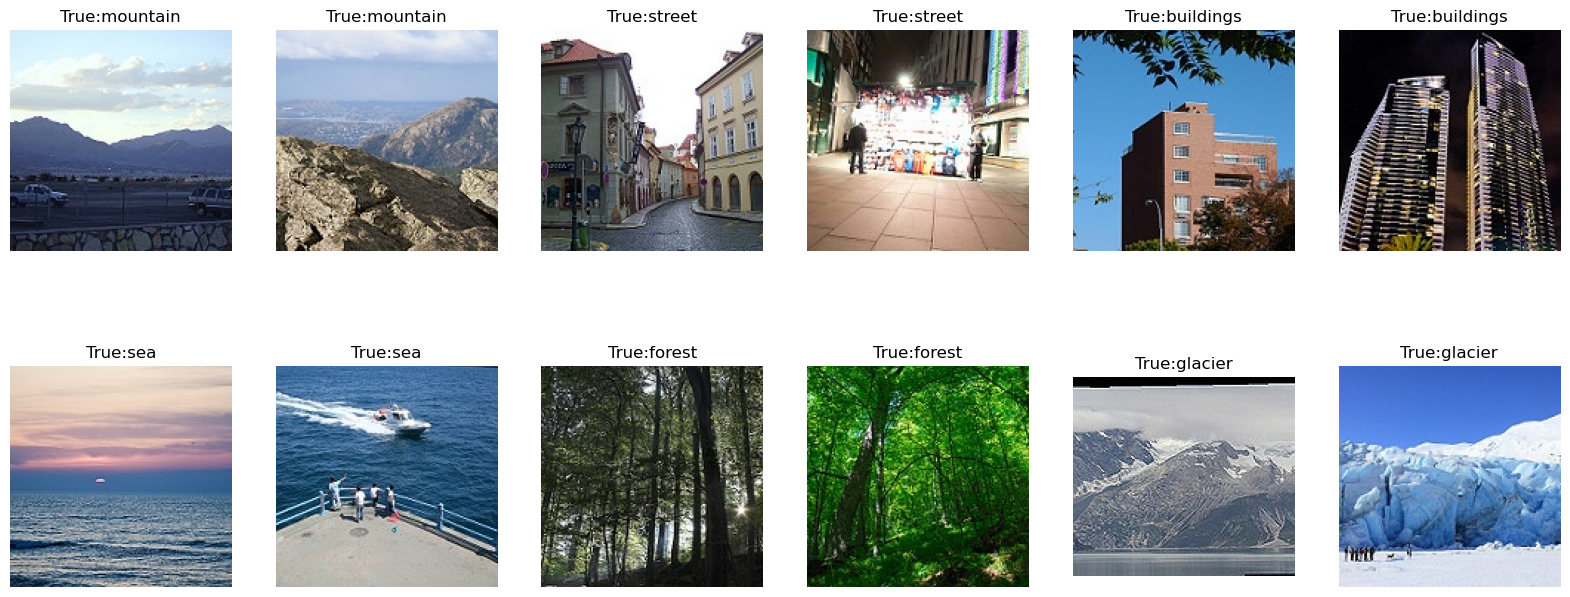

In [7]:
def display_images(number_of_examples=2, model_for_prediction=None):
    figure1, ax1 = plt.subplots(number_of_examples, len(os.listdir(train_folder)), figsize=(20, 4 * number_of_examples))
    ax1 = ax1.reshape(-1)
    disable_axes = np.vectorize(lambda ax: ax.axis('off'))
    disable_axes(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folder)):
        image_ids = os.listdir(os.path.join(train_folder, folder))
        for j in [random.randrange(0, len(image_ids)) for _ in range(0, number_of_examples)]:
            image_display = plt.imread(os.path.join(train_folder, folder, image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(image_display)
            title = 'True:' + folder
            if model_for_prediction:
                predicted_class = inverse_class_mapping[np.argmax(model_for_prediction.predict(np.array([image_display])))]
                title = title + '\nPredicted:' + predicted_class
            ax1[axs].set_title(title)
            axs = axs + 1

display_images(2)


In [8]:
tf.keras.backend.clear_session()
benchmark_epochs = 60
vgg_epochs = 60
resnet_epochs = 60
inception_epochs = 60


In [9]:
benchmark_cnn = Sequential()

benchmark_cnn.add(Conv2D(128, kernel_size=7, activation='relu', input_shape=(150, 150, 3)))
benchmark_cnn.add(MaxPooling2D(pool_size=(4, 4), strides=(2, 2)))
benchmark_cnn.add(Conv2D(64, kernel_size=5, activation='relu'))
benchmark_cnn.add(MaxPooling2D(pool_size=(4, 4), strides=(2, 2)))
benchmark_cnn.add(Flatten())
benchmark_cnn.add(Dense(128, activation='relu'))
benchmark_cnn.add(Dense(6, activation='softmax'))

benchmark_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

benchmark_cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 144, 128)     18944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 67, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 128)               8

Epoch 1/60
439/439 [==============================] - ETA: 0s - loss: 1.1697 - acc: 0.5470
Epoch 1: val_acc improved from -inf to 0.59900, saving model to benchmark_model_01_0.60.hdf5
439/439 [==============================] - 168s 362ms/step - loss: 1.1697 - acc: 0.5470 - val_loss: 0.9750 - val_acc: 0.5990 - lr: 0.0010
Epoch 2/60
439/439 [==============================] - ETA: 0s - loss: 0.8973 - acc: 0.6575
Epoch 2: val_acc improved from 0.59900 to 0.69833, saving model to benchmark_model_02_0.70.hdf5
439/439 [==============================] - 108s 247ms/step - loss: 0.8973 - acc: 0.6575 - val_loss: 0.8048 - val_acc: 0.6983 - lr: 0.0010
Epoch 3/60
439/439 [==============================] - ETA: 0s - loss: 0.7831 - acc: 0.7068
Epoch 3: val_acc improved from 0.69833 to 0.72767, saving model to benchmark_model_03_0.73.hdf5
439/439 [==============================] - 98s 223ms/step - loss: 0.7831 - acc: 0.7068 - val_loss: 0.7138 - val_acc: 0.7277 - lr: 0.0010
Epoch 4/60
439/439 [=========

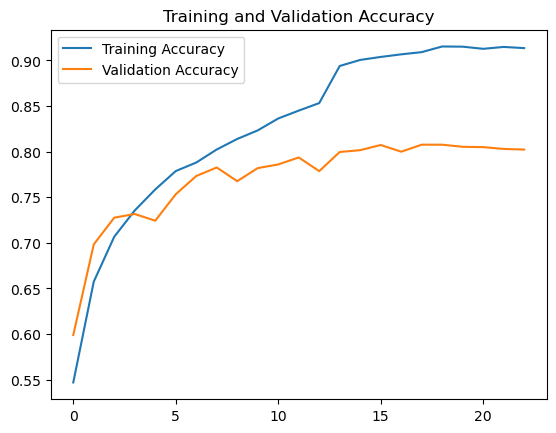

<Figure size 640x480 with 0 Axes>

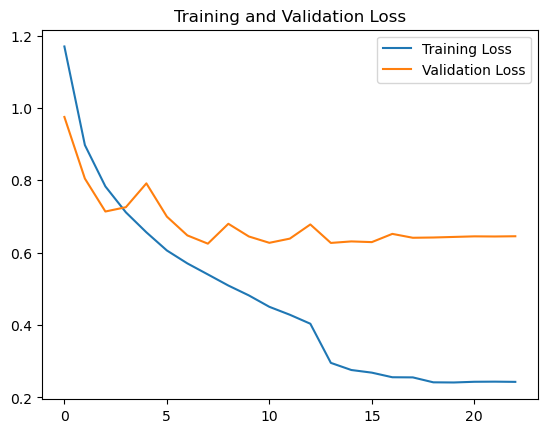

<Figure size 640x480 with 0 Axes>

In [10]:
model_filepath = 'benchmark_model_{epoch:02d}_{val_acc:.2f}.hdf5'
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = benchmark_cnn.fit(train_data_iterator, epochs=benchmark_epochs, verbose=1, validation_data=validation_data_iterator, callbacks=[lr_reduction, early_stopping, model_checkpoint])

benchmark_cnn.save(model_filepath)
process_training_history(history, 'benchmark_model')


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/60
439/439 [==============================] - ETA: 0s - loss: 0.6348 - acc: 0.7702
Epoch 1: val_acc improved from -inf to 0.25200, saving model to vgg16_saved_model_01_acc_0.25.hdf5
439/439 [==============================] - 108s 242ms/step - loss: 0.6348 - acc: 0.7702 - val_loss: 18519.4395 - val_acc: 0.2520
Epoch 2/60
439/439 [==============================] - ETA: 0s - loss: 0.4553 - acc: 0.8288
Epoch 2: val_acc did not improve from 0.25200
439/439 [==============================] - 105s 239ms/step - loss: 0.4553 - acc: 0.8288 - val_loss: 28699.2539 - val_acc: 0.2307
Epoch 3/60
439/439 [==============================] - ETA: 0s - loss: 0.4228 - acc: 0.8444
Epoch 3: val_acc improved from 0.25200 to 0.26967, saving model to vgg16_saved_model_03_acc_0.27.hdf5
439/439 [==============================] - 105s 240ms/step - loss: 0.4228 - acc: 0.8444 - val_loss: 18404.3398 - val_acc: 0.2697
Epoch 4/60
439/439 [========

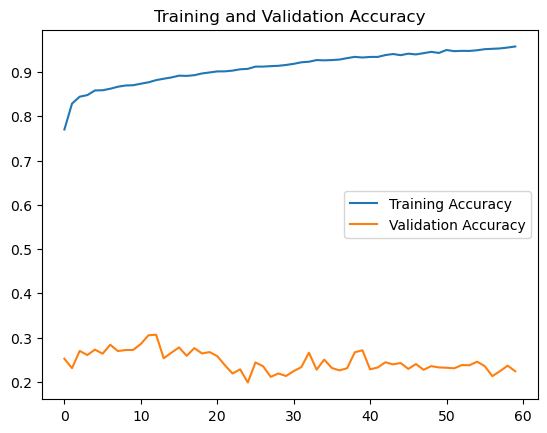

<Figure size 640x480 with 0 Axes>

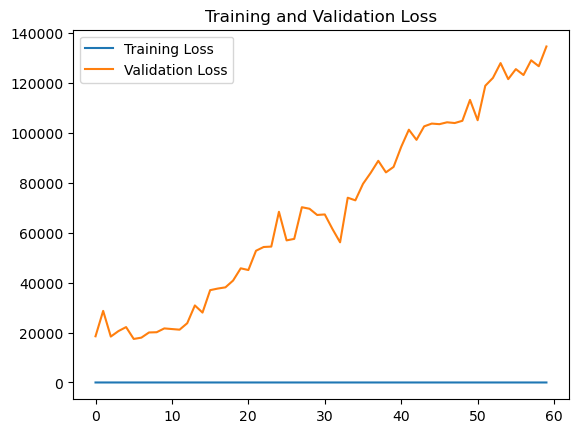

<Figure size 640x480 with 0 Axes>

In [11]:
vgg16_base_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in vgg16_base_model.layers:
    layer.trainable = False
last_output_vgg16 = vgg16_base_model.layers[-1].output
vgg16_x = Flatten()(last_output_vgg16)
vgg16_x = Dense(128, activation='relu')(vgg16_x)
vgg16_x = Dense(6, activation='softmax')(vgg16_x)
vgg16_final_model = Model(vgg16_base_model.input, vgg16_x)
vgg16_final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
epochs_vgg16 = vgg_epochs
vgg16_filepath = 'vgg16_saved_model_{epoch:02d}_acc_{val_acc:.2f}.hdf5'
vgg16_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg16_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vgg16_history = vgg16_final_model.fit(train_data_iterator, epochs=epochs_vgg16, validation_data=validation_data_iterator, callbacks=[vgg16_checkpoint, vgg16_early_stopping], verbose=1)

process_training_history(vgg16_history, 'vgg16_model')


94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/60
439/439 [==============================] - ETA: 0s - loss: 0.4530 - acc: 0.8536
Epoch 1: val_acc improved from -inf to 0.17000, saving model to resnet50_saved_model_01_val_acc_0.17.hdf5
439/439 [==============================] - 136s 295ms/step - loss: 0.4530 - acc: 0.8536 - val_loss: 7.3238 - val_acc: 0.1700 - lr: 0.0100
Epoch 2/60
439/439 [==============================] - ETA: 0s - loss: 0.2011 - acc: 0.9304
Epoch 2: val_acc improved from 0.17000 to 0.80400, saving model to resnet50_saved_model_02_val_acc_0.80.hdf5
439/439 [==============================] - 127s 290ms/step - loss: 0.2011 - acc: 0.9304 - val_loss: 0.5484 - val_acc: 0.8040 - lr: 0.0100
Epoch 3/60
439/439 [==============================] - ETA: 0s - loss: 0.1378 - acc: 0.9492
Epoch 3: val_acc improved from 0.80400 to 0.89967, saving model to resnet50_saved_model_03_val_acc_0.90.hdf5
439/439 [==============================] - 128s 291ms/step - l

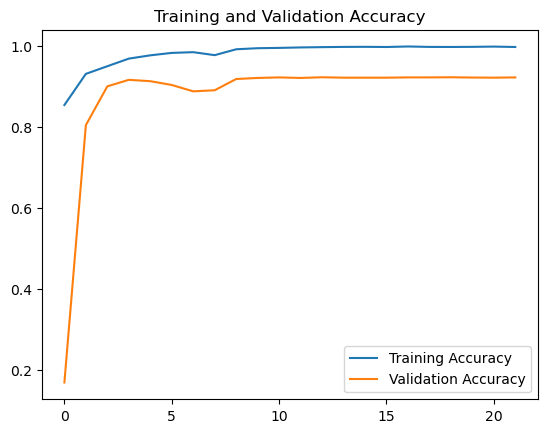

<Figure size 640x480 with 0 Axes>

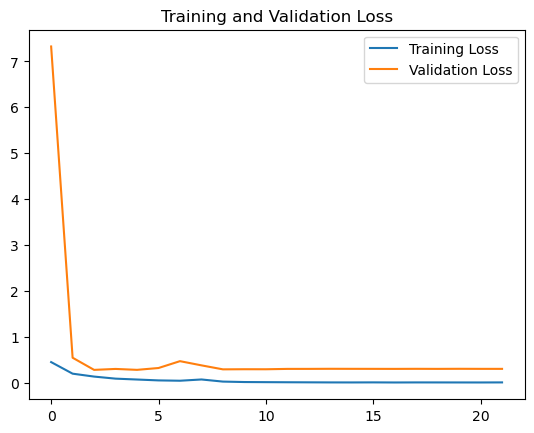

<Figure size 640x480 with 0 Axes>

In [12]:
resnet50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3), classes=6)

for layer in resnet50_base_model.layers:
    layer.trainable = True
optimizer = SGD(learning_rate=0.01, momentum=0.7)
resnet50_x = Flatten()(resnet50_base_model.output)
resnet50_x = Dense(256, activation='relu')(resnet50_x)
resnet50_x = Dense(6, activation='softmax')(resnet50_x)
resnet50_final_model = Model(inputs=resnet50_base_model.input, outputs=resnet50_x)
resnet50_final_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
epochs_resnet50 = resnet_epochs
resnet_filepath = 'resnet50_saved_model_{epoch:02d}_val_acc_{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacks_list = [resnet_checkpoint, resnet_early_stopping, reduce_lr]
resnet50_history = resnet50_final_model.fit(train_data_iterator, epochs=epochs_resnet50, validation_data=validation_data_iterator, callbacks=callbacks_list, verbose=1)

process_training_history(resnet50_history, 'resnet50_model')


87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/60
439/439 [==============================] - 140s 305ms/step - loss: 0.8542 - accuracy: 0.6989 - val_loss: 0.3834 - val_accuracy: 0.8713
Epoch 2/60
439/439 [==============================] - 128s 292ms/step - loss: 0.4412 - accuracy: 0.8457 - val_loss: 0.3076 - val_accuracy: 0.8930
Epoch 3/60
439/439 [==============================] - 128s 291ms/step - loss: 0.3600 - accuracy: 0.8733 - val_loss: 0.2872 - val_accuracy: 0.8967
Epoch 4/60
439/439 [==============================] - 127s 290ms/step - loss: 0.3191 - accuracy: 0.8857 - val_loss: 0.2788 - val_accuracy: 0.8990
Epoch 5/60
439/439 [==============================] - 128s 293ms/step - loss: 0.2968 - accuracy: 0.8926 - val_loss: 0.2675 - val_accuracy: 0.9033
Epoch 6/60
439/439 [==============================] - 129s 293ms/step - loss: 0.2678 - accuracy: 0.9054 - val_loss: 0.2610 - val_accuracy: 0.9037
Epoch 7/60
439/439 [==============================] - 129s 

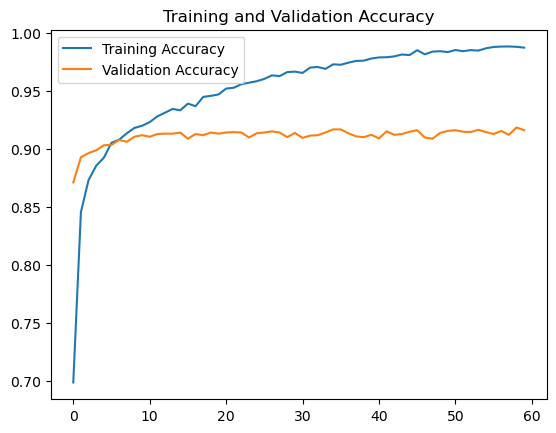

<Figure size 640x480 with 0 Axes>

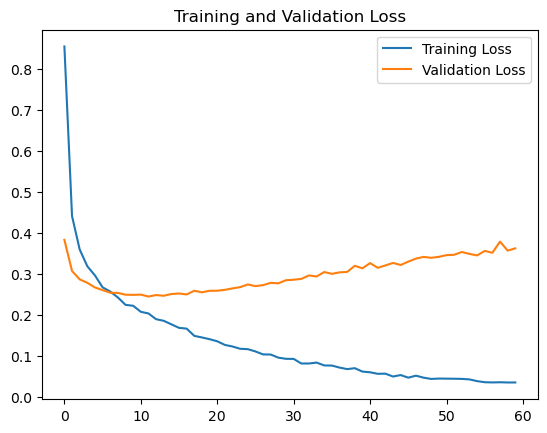

<Figure size 640x480 with 0 Axes>

In [13]:
inceptionv3_base_model = InceptionV3(input_shape=(150, 150, 3), weights='imagenet', include_top=False)
for layer in inceptionv3_base_model.layers[:249]:
    layer.trainable = False
for layer in inceptionv3_base_model.layers[249:]:
    layer.trainable = True
inceptionv3_last_output = inceptionv3_base_model.output
inceptionv3_maxpooled_output = Flatten()(inceptionv3_last_output)
inceptionv3_x = Dense(1024, activation='relu')(inceptionv3_maxpooled_output)
inceptionv3_x = Dropout(0.5)(inceptionv3_x)
inceptionv3_x = Dense(6, activation='softmax')(inceptionv3_x)
inceptionv3_final_model = Model(inputs=inceptionv3_base_model.input, outputs=inceptionv3_x)
inceptionv3_final_model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

epochs_inceptionv3 = inception_epochs
inceptionv3_filepath = 'inceptionv3_saved_model_{epoch:02d}_loss_{loss:.2f}.hdf5'
inceptionv3_checkpoint = tf.keras.callbacks.ModelCheckpoint(inceptionv3_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
inceptionv3_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = inceptionv3_final_model.fit(train_data_iterator, epochs=epochs_inceptionv3, validation_data=validation_data_iterator, callbacks=[inceptionv3_checkpoint, inceptionv3_early_stopping], verbose=1)

process_training_history(inceptionv3_history, 'inceptionv3_model', True)


1/1 [==============================] - 0s 23ms/step
Model Accuracy: 0.6443333333333333
              precision    recall  f1-score   support

   buildings       0.68      0.72      0.70       437
      forest       0.92      0.84      0.88       474
     glacier       0.56      0.36      0.44       553
    mountain       0.68      0.42      0.52       525
         sea       0.48      0.78      0.59       510
      street       0.67      0.80      0.73       501

    accuracy                           0.64      3000
   macro avg       0.67      0.65      0.64      3000
weighted avg       0.66      0.64      0.64      3000



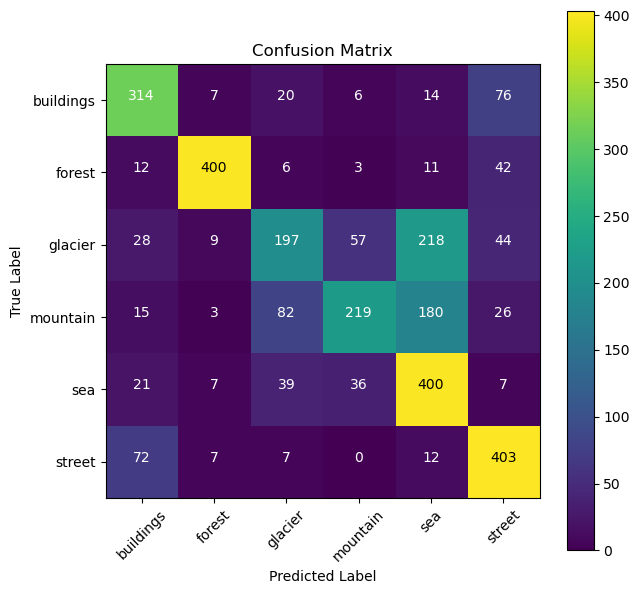

In [21]:
import cv2
best_vgg_model = vgg16_final_model 
best_resnet_model = resnet50_final_model
best_inception_model = inceptionv3_final_model

def find_mode(my_list):
    count = Counter(my_list)
    max_count = max(count.values())
    return [key for key, value in count.items() if value == max_count]

true_values = []
combined_model_predictions = []
vgg_predictions = []
resnet_predictions = []
inception_predictions = []
benchmark_model_predictions = []

for folder in os.listdir(test_folder):
    
    test_image_ids = os.listdir(os.path.join(test_folder, folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(test_folder, folder, image_id)
        
        true_values.append(validation_data_iterator.class_indices[folder])
        img = cv2.resize(cv2.imread(path), (150, 150))
        normalized_img = img / 255
        
        vgg_prediction = np.argmax(best_vgg_model.predict(np.array([normalized_img])))
        vgg_predictions.append(vgg_prediction)
        
        resnet_prediction = np.argmax(best_resnet_model.predict(np.array([normalized_img])))
        resnet_predictions.append(resnet_prediction)
        
        inception_prediction = np.argmax(best_inception_model.predict(np.array([normalized_img])))
        inception_predictions.append(inception_prediction)
        
        benchmark_prediction = np.argmax(benchmark_cnn.predict(np.array([normalized_img])))
        benchmark_model_predictions.append(benchmark_prediction)
        
        image_prediction = find_mode([vgg_prediction, resnet_prediction, inception_prediction])
        combined_model_predictions.append(image_prediction)
    
def classification_res(true_values, model_predictions):
    
    classes = validation_data_iterator.class_indices.keys()
    true_positive_count = [true_values[i] == model_predictions[i] for i in range(len(true_values))]
    model_accuracy = np.sum(true_positive_count) / len(true_positive_count)
    print('Model Accuracy:', model_accuracy)
    
    plt.figure(figsize=(7, 7))
    confusion_mat = confusion_matrix(true_values, model_predictions)
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    threshold = confusion_mat.max() * 0.8
    for i, j in itertools.product(range(confusion_mat.shape[0]), range(confusion_mat.shape[1])):
        plt.text(j, i, confusion_mat[i, j],
                 horizontalalignment="center",
                 color="black" if confusion_mat[i, j] > threshold else "white")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    print(classification_report(true_values, model_predictions, target_names=list(classes)))

classification_res(true_values, benchmark_model_predictions)


Model Accuracy: 0.8053333333333333
              precision    recall  f1-score   support

   buildings       0.96      0.88      0.92       437
      forest       0.93      0.94      0.93       474
     glacier       0.55      0.88      0.68       553
    mountain       0.89      0.43      0.58       525
         sea       0.84      0.85      0.85       510
      street       0.94      0.88      0.91       501

    accuracy                           0.81      3000
   macro avg       0.85      0.81      0.81      3000
weighted avg       0.84      0.81      0.80      3000



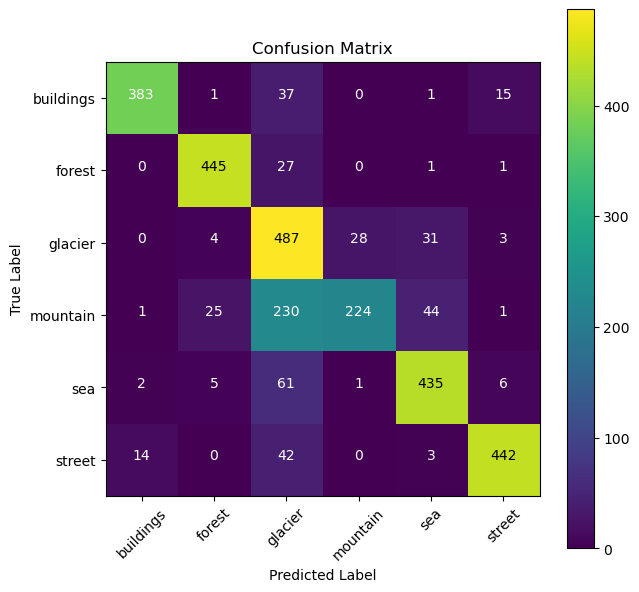

In [22]:
combined_model_pred_flattened = [c[0] for c in combined_model_predictions]
classification_res(true_values, combined_model_pred_flattened)


Model Accuracy: 0.21833333333333332
              precision    recall  f1-score   support

   buildings       0.60      0.04      0.08       437
      forest       0.01      0.00      0.00       474
     glacier       0.20      0.94      0.33       553
    mountain       0.00      0.00      0.00       525
         sea       0.66      0.22      0.33       510
      street       0.05      0.00      0.01       501

    accuracy                           0.22      3000
   macro avg       0.25      0.20      0.12      3000
weighted avg       0.24      0.22      0.13      3000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


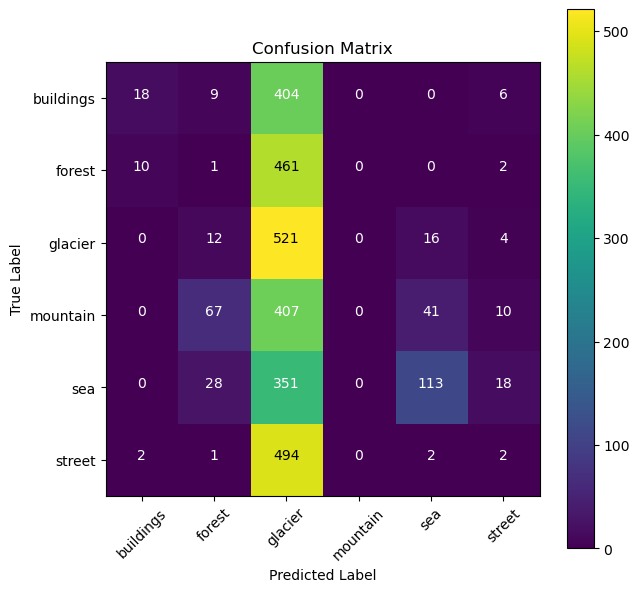

In [23]:
classification_res(true_values, vgg_predictions)



Model Accuracy: 0.8303333333333334
              precision    recall  f1-score   support

   buildings       0.90      0.92      0.91       437
      forest       0.93      0.96      0.95       474
     glacier       0.78      0.67      0.72       553
    mountain       0.78      0.65      0.71       525
         sea       0.70      0.90      0.79       510
      street       0.92      0.93      0.93       501

    accuracy                           0.83      3000
   macro avg       0.84      0.84      0.83      3000
weighted avg       0.83      0.83      0.83      3000



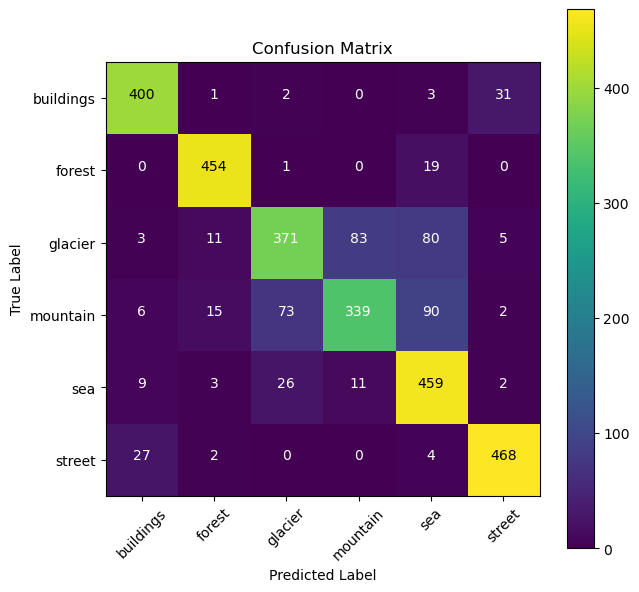

In [24]:
classification_res(true_values, resnet_predictions)

Model Accuracy: 0.833
              precision    recall  f1-score   support

   buildings       0.90      0.92      0.91       437
      forest       0.98      0.97      0.98       474
     glacier       0.69      0.78      0.73       553
    mountain       0.79      0.54      0.64       525
         sea       0.76      0.91      0.83       510
      street       0.92      0.91      0.92       501

    accuracy                           0.83      3000
   macro avg       0.84      0.84      0.83      3000
weighted avg       0.84      0.83      0.83      3000



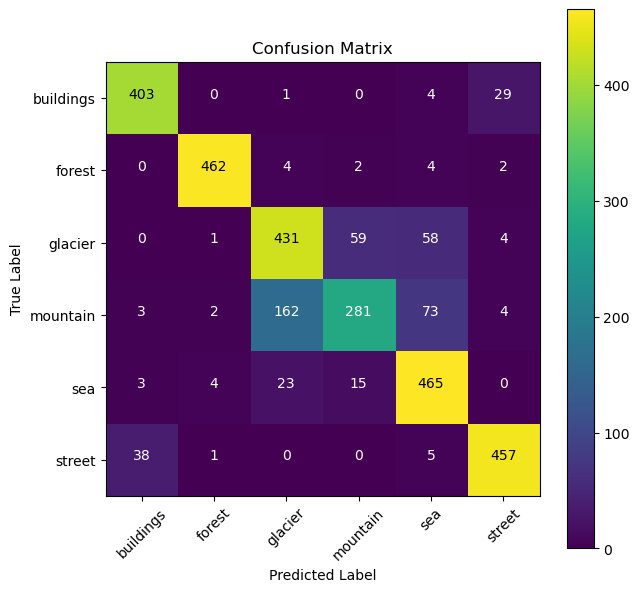

In [25]:
classification_res(true_values, inception_predictions)
